# Primary Component Analysis (PCA)

Using Scikit Learn, apply PCA to reduce the dimension of MNIST (28x28) 

## PCA Pre-requisite

The dataset is centered around the origin. Scikit Learn PCA looks after centering the data. To do it manually by yourself with numpy.

```
X_centered = X - X.mean(axis=0)
```

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

# Split data into training and test
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Mathematics

## Diagonalization
It is able to find the onthogonal bases, in the space of which the co-variances of the data becomes 0.

<img align="left" src="./images/pca/basis.diagonalization.png" width="1000">

## Primary Components

In that space, the variance along each basis is the contribution to the information that the data posseses. The basis along which the data has the maximum variance is the 1st primary component of the data. The basis that has 2nd maximum variance is the 2nd primary compoent, and so on. 

<img align="left" src="./images/pca/basis.variance_is_contribution.png" width="1000"> 

## Eigenvectors

Those onthogonal bases are the eigenvectors and the eigenvalues are the variances. Hence identifying Primary Comonents is calculating the eigenvectors and eigenvalues.

<img align="left" src="./images/pca/basis.variance_to_primary_component.png" width="1000"> 


## Map (Rorate & Extend)
<img align="left" src="./images/pca/basis.rotate_to_map.png" width="400"> 

## Transpose
<img align="left" src="./images/pca/VT.Semantic.png" width="1000"> 

<hr/>

# PCA

The idea of PCA (Primary Component Analysis) is to identify the top <b>k</b> primary components and ignore the rest of the components, by which the dimentionality can be reduced from n to k.

<img align="left" src="./images/pca/pca.idea.png" width="400">
<br/>

## Choosing k

Find <b>k</b> which preseves 99% (or 95%) of the information of the data. <br/>

<cite><b> Andrew Ng</b></cite>
<pre>
<img align="left" src="./images/pca/andrew_ng_choosing_k.png" width="500">
</pre>

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

contributions = pca.explained_variance_ratio_
coverages = np.cumsum(contributions)

In [11]:
k = np.argmax(coverages >= 0.95)

print("Top 3 primary component contributions: {}".format(np.round(contributions[:5], decimals=5)))
print("Coverage by the top 3 primary components: {}".format(np.round(coverages[:5], decimals=5)))
print("k-th primary compoent for 95% coverage is {}".format(k + 1))

Top 3 primary component contributions: [0.09705 0.07096 0.06169 0.05389 0.04869]
Coverage by the top 3 primary components: [0.09705 0.16801 0.2297  0.28359 0.33228]
k-th primary compoent for 95% coverage is 154


<function matplotlib.pyplot.show(*args, **kw)>

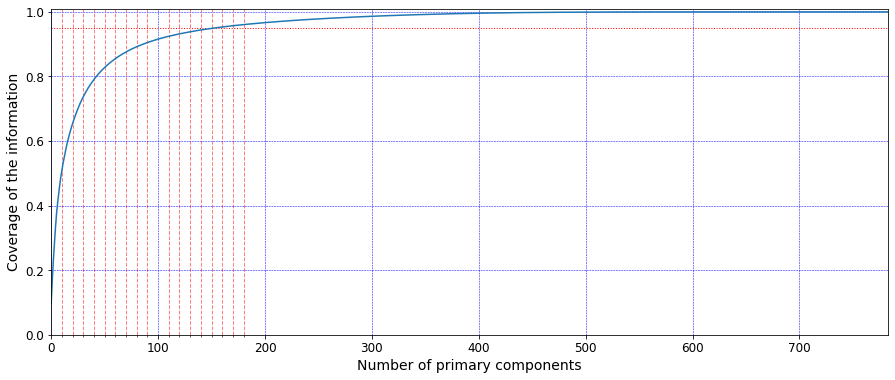

In [7]:
dimensions = range(0, len(contributions))

plt.figure(figsize=(15, 6))

# --------------------------------------------------------------------------------
# Axes
# [Axis limits]
# With plt.axes() you are creating a new axes again. 
# Use ax.set_xlim(a,b) and ax.set_ylim(a,b)
# --------------------------------------------------------------------------------
#plt.axis((0,max(dimensions),0,1.01))
# --------------------------------------------------------------------------------
ax = plt.gca()
ax.set_xlim(0, max(dimensions))
ax.set_ylim(0, 1.01)
ax.set_xlabel("Number of primary components")
ax.set_ylabel("Coverage of the information")

# --------------------------------------------------------------------------------
# Grid
# --------------------------------------------------------------------------------
import math
import matplotlib.ticker as ticker

plt.grid(
    color='b',
    linestyle='--',
    linewidth=0.5,
    which='both'     # Both major and minor grids
)

# Minor grid
minors = range(0, math.ceil(k/100)*100, 10)[1:-1]
ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
ax.grid(
    which='minor', # Set the minor grid attributes
    alpha=0.5,     # Transparency
    lw=1, 
    color='r'
)

# 95% coverage line
plt.plot([0.0, max(dimensions)], [0.95, 0.95], "r:", lw=1)

# --------------------------------------------------------------------------------
# Information coverage along Primary Components 
# --------------------------------------------------------------------------------
plt.plot(dimensions, coverages)
plt.show

# SVD

[We Recommend a Singular Value Decomposition](http://www.ams.org/publicoutreach/feature-column/fcarc-svd)<br>

<img align="left" src="./images/pca/onthgonal_to_onthogonal.png" width="800">

With those (u, v), any matrix M, including a Covariance Matrix, can be decomposed as below.
<br/>
<img align="left" src="./images/pca/SVD.png" width="1000">

The eignvectors of PCA is the same with the singular vector of SVD. <br/>
<img align="left" src="./images/pca/PCA_SVD_Relation.png" width="500">